
### **Chapter 6.1: Introduction to Model Learning**


In this chapter, we introduce the concept of **Model Learning**, which aims to uncover underlying system behaviors from data. When the system's dynamics are not explicitly known or are too complex to model from first principles, we must rely on input–output observations to build approximate models — a process known as **System Identification**.

We begin with **Linear Regression (LR)**, one of the simplest and most foundational techniques in model learning. By using different basis functions, we explore how regression models can approximate a wide range of target functions and analyze how the size and quality of the dataset affect model accuracy.

We then extend to **Bayesian Linear Regression (BLR)**, which not only estimates model parameters but also quantifies uncertainty in predictions. This additional information allows us to make informed decisions, such as where to gather more data for improving highly uncertain areas — an idea known as active learning. BLR also provides smoother and more stable training behavior, especially in low-data regimes.

By the end of this chapter, you will have a solid understanding of how to formulate, implement, and analyze both standard and Bayesian linear regression techniques, setting the stage for more advanced learning-based control strategies.

All the contents are summarized in the table below.  

<style>
  table td:nth-child(2) {
    text-align: left;
  }
</style>

<table border="1" style="border-collapse: collapse;">  <!-- Title Row -->
  <tr>
    <th colspan="2" style="text-align:center">Content of Chapter 6.1 Exercise</th>
  </tr>

  <!-- Row group 2 -->
  <tr>
    <td rowspan="4">Linear Regression</td>
    <td>Example 1.1: Implementation of Linear Regression</td>
  </tr>
  <tr>
    <td>Example 1.2: Expressiveness of Basis Functions</td>
  </tr>
  <tr>
    <td>Example 1.3: Impact of the dataset</td>
  </tr>
  <tr>
    <td>Example 1.4: considerations in real-world application</td>
  </tr>

  <!-- Row group 3 -->
  <tr>
    <td rowspan="2">Bayesian Linear Regression</td>
    <td>Example 2.1: Implementation of Bayesian Linear Regression</td>
  </tr>
  <tr>
    <td>Example 2.2: Bayesian Linear Regression vs. Standard Linear Regression</td>
  </tr>

</table>

<br>

First, we need to set up our Python environment and import relevant packages.

In [1]:
import sys
import os
import numpy as np

sys.path.append(os.path.abspath(".."))
from ex6_SysID.SysID_utils import *

<br>

### **Problem Background: Slope Function From Data**

Imagine you're designing a control system for a small ground robot that must navigate different types of terrain. The robot’s motion is heavily influenced by the slope of the ground beneath it — for example, climbing uphill requires more effort than moving on a flat surface. However, the exact shape or profile of this slope function is unknown in advance.

To enable effective control and planning, your first goal is to **identify** this unknown slope function by collecting data from the real world. In practice, you can measure the height of the terrain at different positions to infer how the slope varies across space.

In this chapter, we consider the same four representative slope function profiles as before, and simulate the data collection process for each case. Your mission is to fit a model to each dataset and uncover the shape of the slope function behind the observed data — a process known as **system identification**.

![Figure 1: Different mountain profile choices](../figure/MountainProfileCases.png)


<br>

### **Data Collection from the Real World**

Before performing system identification, the first crucial step is to gather a dataset from the real world. This is typically done through a sampling process, where we fix an input to the system and measure the corresponding output — each such measurement pair constitutes a data point. By repeating this procedure and collecting a sufficient number of samples, we aim to capture the underlying behavior of the system. This entire process is referred to as data collection.

To better simulate real-world data sampling scenarios, we have prepared a data generation class `GenerateData`. This implementation allows sampling over **multiple disjoint intervals** with **user-defined sample proportions**, while retaining the ability to define symbolic slope functions, add noise, and visualize or export the generated data. The following interfaces are provided:

- Constructor `GenerateData(p_range=[(-2, 2)], p_weights=None, num_samples=100, case=None)`: Initializes with a sampling range, number of samples, and a specific slope function case.

  - `p_range`: A list of tuples defining sampling intervals. Supports multiple disjoint regions.

  - `p_weights`: Optional list specifying the relative proportion of samples drawn from each interval. If omitted, proportions are based on interval length.

  - `num_samples`: Total number of samples to generate across all intervals.

  - `case`: Index of the slope function case to use.

- `generate_data()`: Samples `p` values uniformly from the given range and evaluates the corresponding symbolic slope function `h(p)` with optional Gaussian noise. 

  - Returns a tuple `(p, h)` as the generated dataset.

- `set_noise(mean=0.0, std=0.0)`: Configures the Gaussian noise to be added to the output values during sampling.

- `update_case(new_case)`: Changes the slope function case and rebuilds the corresponding symbolic function.

- `get_symbolic_function()`: 
  
  - Returns the CasADi symbolic function `h(p)` currently used for data generation.

- `save_to_csv(filename)`: Saves the most recently generated dataset (`p`, `h`) to a CSV file.  

  - Requires that `generate_data()` has been called beforehand.

- `load_from_csv(filename)`: Loads a previously saved dataset from a CSV file into memory as `p_current` and `h_current`.

- `plot(show_true_func=True, title=..., ax=None)`: Visualizes the noisy dataset and (optionally) the true symbolic function over all defined intervals.

Below is a usage example of this class:


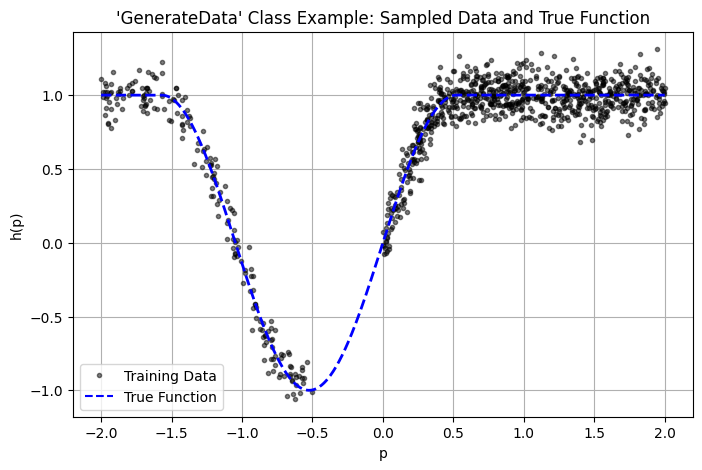

In [2]:
# For reproducibility
np.random.seed(8042)

# Generate the training data
data_gen = GenerateData(p_range=[(-2.0, -0.5), (0.0, 2.0)], p_weights=(0.2, 0.8), num_samples=1000, case=4)
data_gen.set_noise(mean=0.0, std=0.1) # (I.I.D.) zero-mean Gaussian noise
p, h = data_gen.generate_data()
data_gen.plot(title="'GenerateData' Class Example: Sampled Data and True Function")

# You can also save the generated data to a CSV file and load it later
#data_gen.save_to_csv("data_example.csv")
#p_loaded, h_loaded = data_gen.load_from_csv("data_example.csv")
#print("Loaded data:", p_loaded, h_loaded)

<br>

----

### **Part 1: Linear Regression**

#### **Example 1.1: Implementation of Linear Regression**

In this section, we walk through the implementation of a linear regression model for system identification. We begin by reviewing the theoretical foundations of linear regression, followed by a discussion on the choice of basis functions. For each part, we provide corresponding code implementations to illustrate how they can be incorporated into the whole identification framework.

##### **Linear Regression Theory**

We consider the task of learning an unknown function $ f(x_k, u_k) $, representing the uncertain part of the system dynamics, based on a set of paired input-output samples:

$$
\mathcal{D}_f = \left\{ x^{(d)}, u^{(d)}, x_+^{(d)} \right\}_{d=1}^D \quad \mapsto \quad \hat{f},
$$

where the input is given by $ \zeta^{(d)} = \begin{bmatrix} x^{(d)} \\ u^{(d)} \end{bmatrix} $, and the corresponding output is defined as

$$
\gamma^{(d)} = x_+^{(d)},
$$

Assuming that the unknown dynamics $ f $ can be approximated as a linear combination of nonlinear basis functions:

$$
f(x, u) \approx f_{\text{LR}}(\zeta) = \theta^\top \phi(\zeta),
$$

we aim to find a parameter matrix $ \theta \in \mathbb{R}^{B \times n} $, where $ \phi(\zeta) \in \mathbb{R}^B $ is the vector of chosen basis functions, and $ n $ is the output dimension.

To estimate $ \theta $, a common approach is to use **Maximum Likelihood Estimation (MLE)** under the assumption of i.i.d. Gaussian output noise. Given the input matrix $ \Phi \in \mathbb{R}^{D \times B} $ with rows $ \phi(\zeta^{(d)})^\top $, and the output matrix $ \Gamma \in \mathbb{R}^{D \times n} $, the MLE solution is:

$$
\hat{\theta}_{\text{ML}} = (\Phi^\top \Phi)^{-1} \Phi^\top \Gamma,
$$

which coincides with the standard least-squares solution computed by `np.linalg.lstsq`.

Building upon this formulation, we implemented a modular linear regression class that supports arbitrary basis function sets:



In [3]:
# Implementation of LR
def fit(self, p, h):
    p = p.reshape(-1, 1)
    h = h.reshape(-1, 1)
    Phi = np.hstack([f(p) for f in self.basis_functions])  # N x D
    self.theta = np.linalg.lstsq(Phi, h, rcond=None)[0]    # D x 1
    self.p_train = p
    self.h_train = h

This implementation has already been integrated into the `Identifier_LR` class. To use it, you only need to instantiate an object with the desired basis functions and call the `fit()` method to train the model. In addition, `Identifier_LR` defines several other useful interfaces, such as:

- `fit(p, h)`: Fits the linear model using the provided training data.  

  - `p`: input positions (1D NumPy array)  

  - `h`: target values (1D NumPy array)

- `predict(p)`: Computes the model's predicted output for given input positions.  

  - `p`: test input positions (1D NumPy array)


- `get_params()`: Returns the estimated parameter vector `theta`.  

  - Only available after the model has been fitted.

- `reset()`: Resets the internal parameters and clears any previously stored training data.

- `plot(p_test=None, true_func=None, title='Linear Regression', ax=None)`: Plots the fitted curve along with training data, and optionally the ground truth function.

  - `p_test`: optional test inputs used to draw the prediction curve  

  - `true_func`: optional callable representing the true function `h(p)`  

  - `title`: optional title for the plot  
  
  - `ax`: optional Matplotlib `Axes` object for drawing within a subplot

All basis functions should be callables that accept a `(D, 1)` array and return a `(D, 1)` array.


<br>

##### **Basis Functions in Linear Regression**

In linear regression and function approximation, the choice of **basis functions** plays a key role in capturing the underlying structure of the target function. Commonly-used basis function sets include:

1) **Polynomial basis**  

   These are monomial terms of the form $ \phi(\zeta) = \zeta^i $, where $ i \in \mathbb{N} $. Polynomial basis functions are simple and interpretable, making them a natural choice for many regression problems. However, high-degree polynomials can suffer from numerical instability and overfitting.

2) **Trigonometric basis**  

   These include $ \phi(\zeta) = \sin(k\zeta) $ and $ \phi(\zeta) = \cos(k\zeta) $, where $ k $ is the frequency. They are the building blocks of **Fourier series**, which are powerful tools for approximating periodic functions. Trigonometric bases are especially useful when modeling data with inherent oscillatory behavior.

3) **Other basis functions**  

   In addition to polynomials and trigonometric functions, more advanced basis functions can be used:

   - **Radial Basis Functions (RBFs)**, such as $ \phi(\zeta) = \exp(-\gamma(\zeta - c)^2) $, provide localized support and are commonly used in kernel methods.

   - In fact, **Polynomial series**, **Fourier series** (built from trigonometric functions) and **RBFs** are all capable of **universal approximation** under appropriate conditions, making them valuable in highly expressive function models.



To simplify the construction of such basis sets, we provide a utility function `generate_basis_functions()` that allows you to automatically generate combinations of polynomial and trigonometric functions with configurable orders and frequencies. This function is especially useful when you want to quickly assemble a customized basis set for linear or Bayesian linear regression.

**Parameters:**

- `include_offset`: Whether to include the constant bias term $ \phi(\zeta) = 1 $

- `include_polynomial`: Whether to include polynomial terms $ \zeta^i $

- `include_trigonometric`: Whether to include trigonometric terms $ \sin(k\zeta) $, $ \cos(k\zeta) $

- `min_poly_order`, `max_poly_order`: Range of polynomial degrees $ i $

- `min_freq`, `max_freq`: Range of trigonometric frequencies $ k $

**Returns:**

- A list of callable basis functions. Each basis function $ \phi_1(\zeta), ... , \phi_B(\zeta) $ accepts a NumPy array of shape `(D, 1)` or `(D,)` and returns a transformed column vector of shape `(D, 1)`.

This utility gives you flexibility to control model complexity while working within a unified and modular framework for basis construction.

In [4]:
def generate_basis_functions(include_offset=True,
                              include_polynomial=True,
                              include_trigonometric=True,
                              min_poly_order=1,
                              max_poly_order=10,
                              min_freq=1,
                              max_freq=10):
    """
    Generate a list of basis functions for use in linear regression or Bayesian regression.

    Parameters:
    - include_offset: whether to include the constant 1 term
    - include_polynomial: whether to include polynomial terms p^i
    - include_trigonometric: whether to include sin(kp) and cos(kp) terms
    - min_poly_order: lowest polynomial degree to include
    - max_poly_order: highest polynomial degree to include
    - min_freq: lowest frequency k for trig functions
    - max_freq: highest frequency k for trig functions

    Returns:
    - basis: a list of callable functions, each \phi(\zeta) taking \zeta as (D, 1) or (D,) array
    """
    basis = []

    # Offset term
    if include_offset:
        basis.append(lambda p: np.ones_like(p))

    # Polynomial terms
    if include_polynomial:
        for i in range(min_poly_order, max_poly_order + 1):
            basis.append(lambda p, i=i: p**i)

    # Trigonometric terms
    if include_trigonometric:
        for k in range(min_freq, max_freq + 1):
            basis.append(lambda p, k=k: np.sin(k * p))
            basis.append(lambda p, k=k: np.cos(k * p))
    
    # TODO: Add other basis functions as needed (EG: RBFs, etc.)

    return basis

<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **🔍 Hands-on Exploration 1: try to implement RBFs yourself**

Now that you've seen how to build polynomial and trigonometric basis functions, try extending the model by implementing more expressive basis functions yourself — for example, **Radial Basis Functions (RBFs)**, defined as:

$$
\phi(\zeta) = \exp\left( -\gamma (\zeta - c)^2 \right)
$$

where $ c $ is the center and $ \gamma $ controls the width.  

You are encouraged to create a set of RBFs with different centers and widths, and integrate them into the same regression framework.
</blockquote>


<br>

#### **Example 1.2: Expressiveness of Basis Functions**

In this example, we extend the previously introduced **Linear Regression (LR)** implementation to perform parameter identification. Our goal is to evaluate the **expressiveness and capacity of different basis function combinations** by using them to identify various slope profiles.  

*Note that: To isolate the representational power of the basis functions themselves, we deliberately simplify the setup by assuming noise-free sampling, i.e., the collected data exactly reflects the true height $ h $ at any given position $ p $.*


##### **Case 1: Polynomial Basis Function to identify Linear Slope (Profile 2)**

We begin our discussion with the simplest case. **Profile 2** represents an inclined straight line, corresponding to a slope with constant inclination. In this scenario, a **first-order polynomial basis** is sufficient to achieve a good fit. The specific parameter settings are shown below:

- Target function: **Profile 2**

- Size of dataset: **100 input-output pairs** 

- Sampling noise: None

- Basis functions: 1) constant offset $ \phi(\zeta) = 1 $;  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2) 1-order polynomial term $ \phi(\zeta) = \zeta $;

[[-6.16901688e-18]
 [ 1.74532925e-01]]


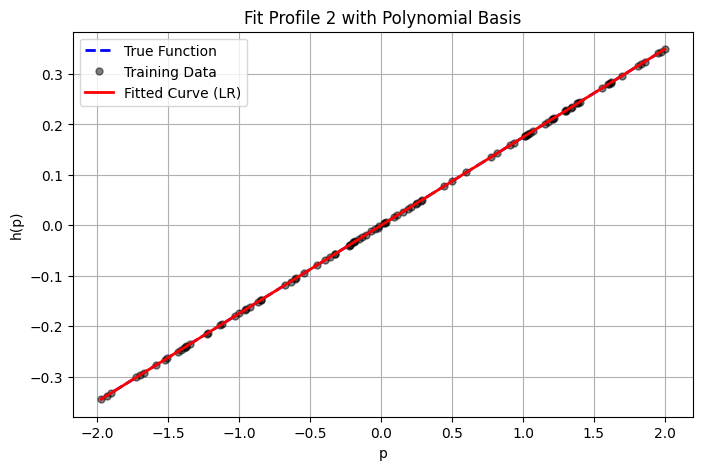

In [5]:
# Generate the training data
data_gen = GenerateData(num_samples=100, case=2)
#data_gen.set_noise(mean=0.0, std=0.1) # default for no noise
p, h = data_gen.generate_data()


# Generate basis functions
basis = []
# Offset term: constant
basis.append(lambda p: np.ones_like(p))
# Polynomial part: linear
basis.append(lambda p: p)


# Fit the model using linear regression
model_lr = Identifier_LR(basis)
model_lr.fit(p, h)
print(model_lr.get_params())


# Visualize the results
true_func = data_gen.get_symbolic_function()
model_lr.plot(true_func=true_func, title='Fit Profile 2 with Polynomial Basis')

##### **Results Analysis**

The fitted curve (red) closely overlaps with the true function (blue dashed), demonstrating that the first-order polynomial basis successfully captures the linear structure of Profile 2.

*Note that: in the absence of noise, adding superfluous basis functions—such as the constant offset term in this case—has no adverse effect on the fitting result, as the optimizer naturally assigns them negligible weights.*


<br>

##### **Case 2: Identifying Bumpy Road (Profile 3)**

Next, we consider another typical case: **Profile 3**, which corresponds to a periodic function with a frequency of 18. The specific parameter settings in this task are summarized below:

- Target function: **Profile 3**

- Size of dataset: **100 input-output pairs** 

- Sampling noise: None

We begin by attempting to perform the identification using polynomial basis functions as before, to see what kind of result we obtain in this more challenging scenario.

- Basis functions: 1) constant offset $ \phi(\zeta) = 1 $;   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2) polynomial series $ \phi(\zeta) = \zeta^i $ with $ i \in [1, ..., 10] $; 

[[-0.00061543]
 [-0.00230748]
 [-0.00132106]
 [ 0.00744262]
 [ 0.00965951]
 [-0.00684106]
 [-0.00889076]
 [ 0.00237823]
 [ 0.00294466]
 [-0.0002774 ]
 [-0.00033491]]


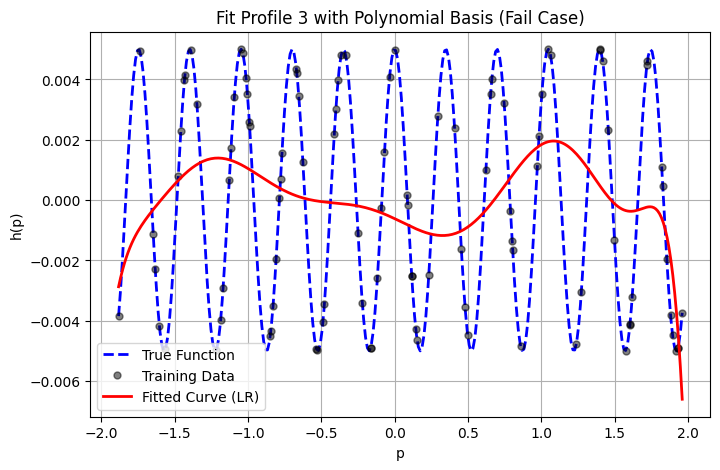

In [6]:
# Generate the training data
data_gen = GenerateData(num_samples=100, case=3)
#data_gen.set_noise(mean=0.0, std=0.1) # default for no noise
p, h = data_gen.generate_data()


# Define basis functions
include_offset=True
include_polynomial=True
include_trigonometric=False
min_poly_order=1
max_poly_order=10

# Generate basis functions
basis = generate_basis_functions(include_offset, include_polynomial, include_trigonometric, min_poly_order, max_poly_order)



# Fit the model using linear regression
model_lr = Identifier_LR(basis)
model_lr.fit(p, h)
print(model_lr.get_params())


# Visualize the results
true_func = data_gen.get_symbolic_function()
model_lr.plot(true_func=true_func, title='Fit Profile 3 with Polynomial Basis (Fail Case)')

The fitting result shows that using a polynomial basis fails to capture the oscillatory behavior of the target function. Despite following the overall trend near the center, the model cannot represent the high-frequency periodic structure. This suggests that a trigonometric basis—which is naturally suited for periodic functions—would be a more appropriate choice for this identification task.

- Basis functions: trigonometric term with related frequency $ \phi(\zeta) = \sin(18 \zeta) $ and $ \phi(\zeta) = \cos(18 \zeta) $

[[3.14601625e-19]
 [5.00000000e-03]]


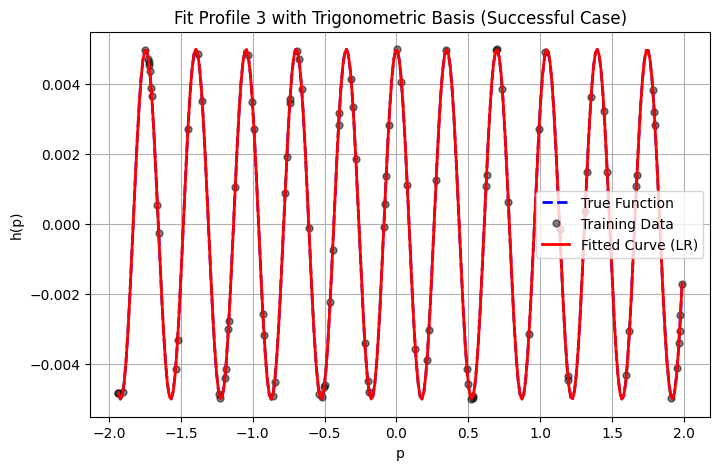

In [7]:
# Generate the training data
data_gen = GenerateData(num_samples=100, case=3)
#data_gen.set_noise(mean=0.0, std=0.1) # default for no noise
p, h = data_gen.generate_data()


# Generate basis functions
basis = []
# Trigonometric part:
basis.append(lambda p: np.sin(18 * p))
basis.append(lambda p: np.cos(18 * p))


# Fit the model using linear regression
model_lr = Identifier_LR(basis)
model_lr.fit(p, h)
print(model_lr.get_params())


# Visualize the results
true_func = data_gen.get_symbolic_function()
model_lr.plot(true_func=true_func, title='Fit Profile 3 with Trigonometric Basis (Successful Case)')

##### **Results Analysis**

The fitting result shows a perfect alignment between the fitted curve and the true periodic profile, confirming that trigonometric basis functions can effectively capture high-frequency oscillations.

*Note that: when using trigonometric basis functions, we typically include both sine and cosine terms of the same frequency. This is because the phase of the target signal is often unknown, and by the angle addition identity, any phase-shifted sine wave can be expressed as a linear combination of sine and cosine terms. The appropriate frequency of the basis functions can usually be inferred visually from the waveform of the target function.*


<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **💡 Take-away 1: Matching Basis to Characteristics of Target Function**

If we have some **prior knowledge** about the target function or observe certain **distinct features** (e.g., periodicity, smoothness), we can leverage this information to guide the **selection of basis functions**. For example:

- The **polynomial basis** is a natural and effective choice for fitting **smooth, non-periodic functions** such as straight lines or parabolas. 

- The **trigonometric basis functions** are more suitable for modeling **periodic profiles**, as they can easily capture oscillatory behavior through sine and cosine terms.

*Note that: This idea is supported by foundational results like* the Weierstrass Approximation Theorem for polynomials and the Fourier Approximation Theorem for trigonometric series, which guarantee universal approximation capability under suitable conditions.*

</blockquote>


<br>

##### **Case 3: A Set of Basis Functions to Identify the Valley (Profile 4)**

In the first two examples, the target functions to be identified exhibit clear and distinctive features, making their analytical expressions easy to infer at a glance.
However, in most real-world parameter identification problems, this is rarely the case. We now turn to a more complex scenario: **Profile 4**, which is defined as a piecewise function:

$$
h(p) =
\begin{cases}
\sin(3p), & p \in \left[-\frac{\pi}{2}, \frac{\pi}{6}\right] \\
1, & p \in (-\infty, -\frac{\pi}{2}) \cup \left(\frac{\pi}{6}, \infty\right)
\end{cases}
$$

This profile exhibits both **local periodic behavior** and **non-smooth discontinuities**, making it more challenging to model using a single type of basis function. Since we no longer assume prior knowledge of the function's exact analytical form, we must provide the model with **greater expressive capacity**. To that end, we combine both **polynomial** and **trigonometric** basis functions to ensure that the model can approximate the overall structure of this complex, piecewise-defined profile. The specific parameter configuration is summarized below:

- Target function: **Profile 4**

- Size of dataset: **100 input-output pairs** 

- Sampling noise: None

- Basis functions: 1) constant offset $ \phi(\zeta) = 1 $;   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2) polynomial series $ \phi(\zeta) = \zeta^i $ with $ i \in [1, ..., 2] $;   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3) trigonometric series $ \phi(\zeta) = \sin(k \zeta) $ and $ \phi(\zeta) = \cos(k \zeta) $ with $ k \in [1, ..., 2] $;

*Note that: here you can use the basis function helper we defined before to generate the basis function set easily.*


In [8]:
# Define basis functions
include_offset=True
include_polynomial=True
include_trigonometric=True
min_poly_order=1
max_poly_order=2
min_freq=1
max_freq=2

[[ 10.93122069]
 [  3.26611335]
 [ -3.5690079 ]
 [ -5.22809912]
 [-12.02591143]
 [  2.04006846]
 [  1.09859295]]


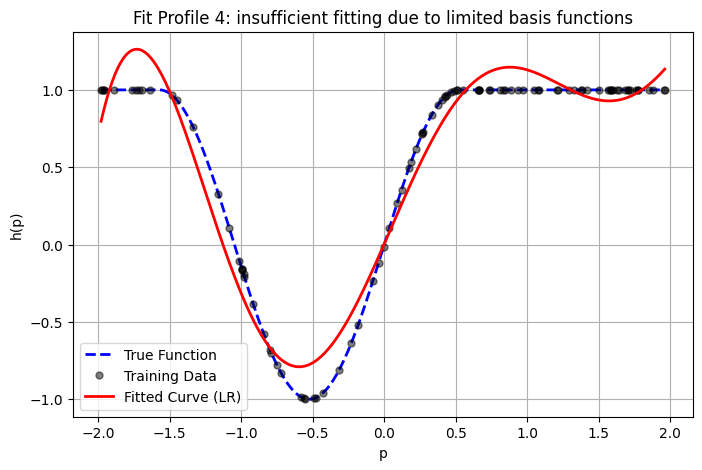

In [9]:
# Generate the training data
np.random.seed(49) # for reproducibility
data_gen = GenerateData(num_samples=100, case=4)
#data_gen.set_noise(mean=0.0, std=0.1) # default for no noise
p, h = data_gen.generate_data()


# Generate basis functions
basis = generate_basis_functions(include_offset, include_polynomial, include_trigonometric, min_poly_order, max_poly_order, min_freq, max_freq)


# Fit the model using linear regression
model_lr = Identifier_LR(basis)
model_lr.fit(p, h)
print(model_lr.get_params())


# Visualize the results
true_func = data_gen.get_symbolic_function()
model_lr.plot(true_func=true_func, title='Fit Profile 4: insufficient fitting due to limited basis functions')

From the fitting result, we observe that when the maximum orders of the polynomial and trigonometric basis functions are set to $2$, the fitted function already captures the general trend of the target function reasonably well. However, noticeable deviations still occur in certain regions. To address this, we increase the maximum order of the basis functions to $10$ and investigate whether the fitting accuracy can be further improved.

- Basis functions: 1) constant offset $ \phi(\zeta) = 1 $;   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2) polynomial series $ \phi(\zeta) = \zeta^i $ with $ i \in [1, ..., 10] $;   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3) trigonometric series $ \phi(\zeta) = \sin(k \zeta) $ and $ \phi(\zeta) = \cos(k \zeta) $ with $ k \in [1, ..., 10] $;

In [10]:
# Define basis functions
include_offset=True
include_polynomial=True
include_trigonometric=True
min_poly_order=1
max_poly_order=10
min_freq=1
max_freq=10


[[-4.82395107e+06]
 [ 1.50822390e+04]
 [-6.59223537e+06]
 [ 1.09636544e+05]
 [ 1.23132337e+07]
 [-5.44356018e+04]
 [-3.52897882e+06]
 [ 7.59013772e+03]
 [ 3.57450340e+05]
 [-3.30719452e+02]
 [-1.24379600e+04]
 [-3.60812438e+03]
 [-1.01880099e+06]
 [-1.07800205e+05]
 [ 1.45434016e+07]
 [ 8.84890323e+04]
 [-1.00839383e+07]
 [-1.96668206e+04]
 [ 1.61455809e+06]
 [ 4.41986136e+03]
 [-2.71055274e+05]
 [-1.00040062e+03]
 [ 4.63439129e+04]
 [ 2.16361006e+02]
 [-7.50891384e+03]
 [-4.17001159e+01]
 [ 1.05801581e+03]
 [ 6.41545484e+00]
 [-1.14112067e+02]
 [-6.11157465e-01]
 [ 7.07272436e+00]]


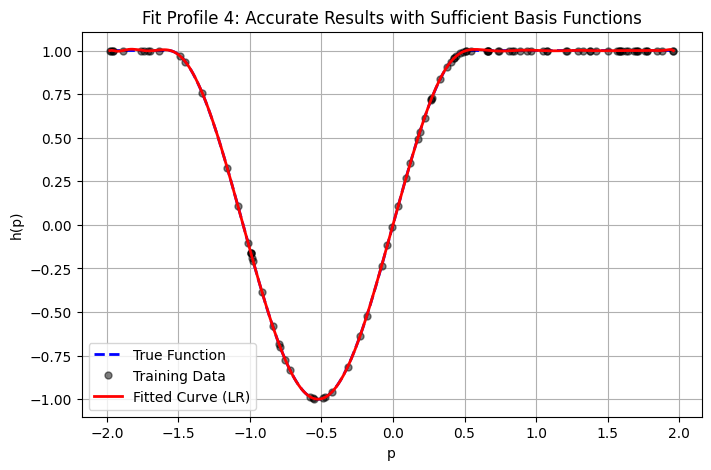

In [11]:
# Generate the training data
np.random.seed(49) # for reproducibility
data_gen = GenerateData(num_samples=100, case=4)
#data_gen.set_noise(mean=0.0, std=0.1) # default for no noise
p, h = data_gen.generate_data()


# Generate basis functions
basis = generate_basis_functions(include_offset, include_polynomial, include_trigonometric, min_poly_order, max_poly_order, min_freq, max_freq)


# Fit the model using linear regression
model_lr = Identifier_LR(basis)
model_lr.fit(p, h)
print(model_lr.get_params())


# Visualize the results
true_func = data_gen.get_symbolic_function()
model_lr.plot(true_func=true_func, title='Fit Profile 4: Accurate Results with Sufficient Basis Functions')

##### **Results Analysis**

The fitting result demonstrates that, despite the piecewise nature of Profile 4, the model, equipped with a richer combination of high-order polynomial and trigonometric basis functions, still successfully captures the global structure of the target function. The predicted curve aligns almost perfectly with the ground truth across the entire domain. 

However, the estimated coefficients span several orders of magnitude, indicating that the model relies heavily on high-order components to approximate sharp transitions, which may lead to numerical sensitivity.


<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **💡 Take-away 2: a richer basis set improves expressiveness**

In the ideal case (no noise), **if we do not have prior knowledge about the structure of the target function**, it is beneficial to **include a broader set of basis functions** (e.g., combining polynomial and trigonometric terms) to increase the model’s expressiveness and fitting capability.

</blockquote>


However, incorporating more basis functions leads to a more complex model, which in turn increases the computational cost during online inference—especially when the model is used for control tasks. This trade-off naturally motivates the need for **model reduction**, where a simpler yet sufficiently expressive model is derived to balance accuracy and efficiency. A simple approach to model reduction is to fit the system using fewer basis functions and examine whether it still achieves comparable approximation accuracy.

<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **🔍 Hands-on Exploration 2: Model Reduction through Fewer Basis Functions**

Try to reduce the number of basis functions while maintaining a good fit. Can you find a simpler combination that still captures the essential features of the target profile?

*Hint: Either a polynomial series or a trigonometric series alone can be expressive enough for this task. You may try fixing the basis function type to one of them and play with the minimum and maximum orders.*

</blockquote>

Another commonly-used approach is to use more expressive basis functions (e.g., RBFs) as the new basis, allowing you to capture complex behaviors with fewer terms, thereby reducing the overall model complexity.

<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **🔍 Hands-on Exploration 3: Model Reduction through Expressive Basis Design**

Try to use a more expressive basis function set such as **Radial Basis Functions (RBFs)** to perform the same curve fitting task and observe whether you can achieve a similar or better fitting accuracy **with fewer basis functions** compared to polynomial or trigonometric sets.

</blockquote>

<br>

#### **Example 1.3: Impact of the Dataset**

In the previous example, we demonstrated how the choice of basis functions influences the quality of curve fitting. In this example, we shift our focus to another critical factor: **the dataset itself**.

One of the most important characteristics of a dataset is its size—that is, the number of available training samples. In this experiment, we fix the parameter identification task (with task settings specified below) and vary the number of training samples used. Our goal is to investigate how the dataset size affects the resulting fitted model and its performance. 

- Target function: **Profile 4**

- Size of dataset: **1000 input-output pairs** 

- Sampling noise: None

- Basis functions: 1) constant offset $ \phi(\zeta) = 1 $; 2) polynomial series $ \phi(\zeta) = \zeta^i $ with $ i \in [1, ..., 10] $

*Note that: To isolate the effect of dataset size, we continue to assume noise-free sampling, i.e., each sample provides an accurate evaluation of the true function.*

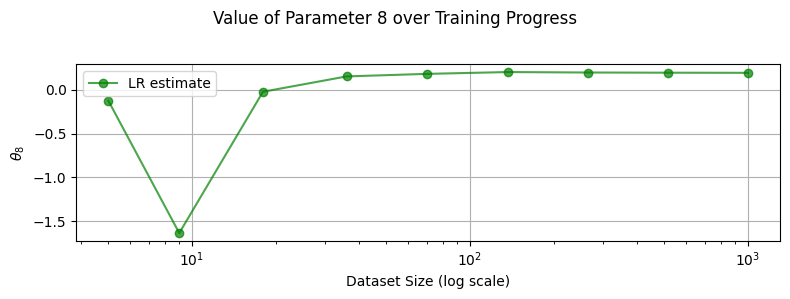

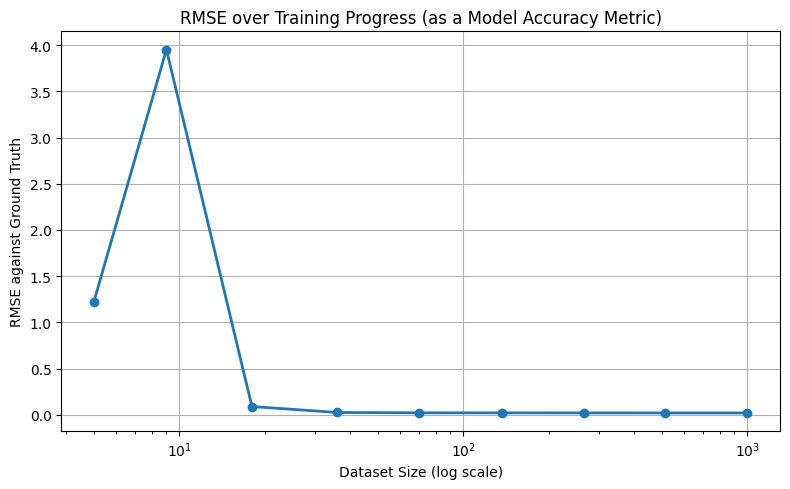

In [12]:
# Generate the training data
np.random.seed(8042) # for reproducibility
data_gen = GenerateData(num_samples=1000, case=4)
#data_gen.set_noise(mean=0.0, std=0.0) # default for no noise
p, h = data_gen.generate_data()


# Define basis functions
include_offset=True
include_polynomial=True
include_trigonometric=False
min_poly_order=1
max_poly_order=10


# Generate basis functions
basis = generate_basis_functions(include_offset, include_polynomial, include_trigonometric, min_poly_order, max_poly_order)


# Fit the model using linear regression
model_lr = Identifier_LR(basis)
model_lr.fit(p, h)


# Visualize the results
true_func = data_gen.get_symbolic_function()
plot_param_over_sample_size(p, h, model_lr, plot_dims=[8], title='Value of Parameter 8 over Training Progress')
plot_rmse_over_sample_size(p, h, model_lr, true_func, title='RMSE over Training Progress (as a Model Accuracy Metric)')

#### **Results Analysis**

As shown in the figure above, we observe how the learned parameters of the Linear Regression model evolve as the dataset size increases. Two representative parameters, $\theta_1$ and $\theta_8$, are visualized. We can clearly see that:

- As the dataset grows, the parameter estimates gradually converge toward stable values, reflecting the consistency of the model under the Law of Large Numbers.

- However, when the dataset is small, the estimated parameters fluctuate significantly and fail to settle at meaningful values.


To quantify and better visualize the impact of dataset size, we extract and compare the full fitting results for several representative sample sizes $D = \{8, 10, 100, 1000\}$. The corresponding plots are shown below:

In [13]:
# Display animation to show the fitting result at given iteration index sequentially
true_func = data_gen.get_symbolic_function()
animate_training_progress(p, h, model_lr, sample_indices=[8, 10, 100, 1000], true_func=true_func, title='Linear Regression Model at several typical dataset sizes')

These plots illustrate how the fitting performance of a linear regression model evolves as the dataset size increases while the model structure (i.e., the basis function set) remains fixed:

- When the dataset is small (e.g., size = 8 or 10), the fitted curve shows severe oscillations and deviates significantly from the true underlying function. The model tends to “forcefully pass through” the limited training points, leading to poor generalization. This is a typical case of overfitting.

- As the dataset size increases (e.g., 100 or 1000), the fitted curve becomes smoother and closely aligns with the true function. The training error decreases, and the model demonstrates strong generalization capability.

From a deeper perspective, the root cause of overfitting in this context lies in the expressiveness of the chosen basis function set. In order to capture the complexity of the target function, a rich basis set is used, providing the model with high capacity. However, when the number of training samples is small, there are too many degrees of freedom relative to the constraints provided by the data. As a result, the model has the flexibility to fit not only the signal but also incidental noise or fluctuations in the data. This imbalance—high model complexity with low data volume—leads to overfitting.

<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **💡 Take-away 3: You may want more data when the model is complex**

To guarantee a suffcient training, **the size of the dataset** you use should match the complexity of **the undelying model** as well as **the chosen set of basis functions**.

</blockquote>


<br>

#### **Example 1.4: Real-World Considerations**

In contrast to the idealized settings discussed in previous examples, data collected from real-world systems is often contaminated with measurement noise. When such noisy datasets are used for parameter identification, the presence of noise can significantly degrade the estimation quality. In this section, we will explore how noise affects the performance of parameter estimation and discuss strategies to mitigate its impact in practice.

##### **Case 1: Reducing the Impact of Noise**
      
When dealing with noisy measurements, it's essential to adopt strategies that can mitigate their negative effects on parameter identification. One common approach is to apply a denoising technique such as a low-pass filter during data pre-processing. However, this requires prior knowledge about the noise characteristics—for example, its bandwidth or the presence of time delay—which may not always be available.

Alternatively, increasing the size of the dataset $D$ is a more general and robust way to suppress the influence of noise. As we will show in the following example, the variance of the estimated parameters tends to decrease as more samples are included, making the model more stable and reliable in the presence of noisy data.


In this exercise, you are encouraged to test how the number of training samples affects the robustness of parameter identification in the presence of noise. Try setting the sample size to 100 / 1000 / 10000, and observe how the identified parameters converge (or fluctuate) by comparing the printed results with the ground-truth model parameters.

[[-0.0148161 ]
 [ 0.15166393]]
Ground truth: [0.0, 0.1745]


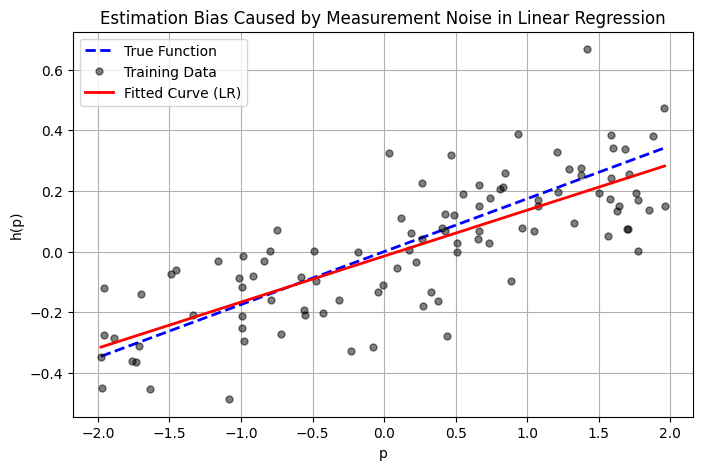

In [14]:
# Generate the training data
np.random.seed(49) # for reproducibility
data_gen = GenerateData(num_samples=100, case=2) # from 100 to 1000 to 10000
data_gen.set_noise(mean=0.0, std=0.15) # (I.I.D.) zero-mean Gaussian noise
p, h = data_gen.generate_data()


# Generate basis functions
basis = []
# Offset term: constant
basis.append(lambda p: np.ones_like(p))
# Polynomial part: linear
basis.append(lambda p: p)


# Fit the model using linear regression
model_lr = Identifier_LR(basis)
model_lr.fit(p, h)
print(model_lr.get_params())
print(f"Ground truth: {[0.0, 0.1745]}")


# Visualize the results
true_func = data_gen.get_symbolic_function()
model_lr.plot(true_func=true_func, title="Estimation Bias Caused by Measurement Noise in Linear Regression")

We have prepared a convenient visualization tool for the training process. By running the code block below, you can directly observe how the identified parameters evolve as the dataset size increases under the influence of noise. The **ground-truth of parameter** is also plotted for easy comparison.

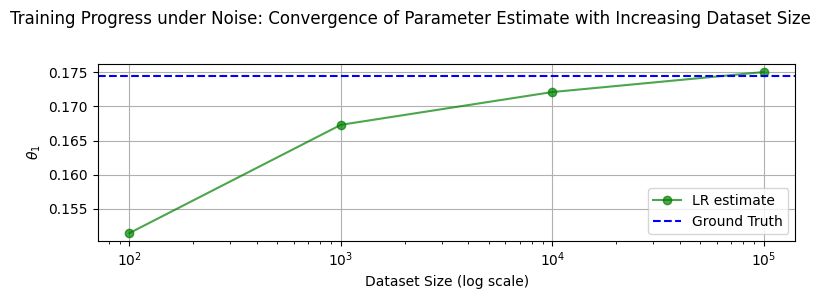

In [15]:
# Generate the training data
np.random.seed(49) # for reproducibility
data_gen = GenerateData(num_samples=100000, case=2) # from 100 to 1000 to 10000
data_gen.set_noise(mean=0.0, std=0.15) # (I.I.D.) zero-mean Gaussian noise
p, h = data_gen.generate_data()


# Generate basis functions
basis = []
# Offset term: constant
basis.append(lambda p: np.ones_like(p))
# Polynomial part: linear
basis.append(lambda p: p)


# Fit the model using linear regression
model_lr = Identifier_LR(basis)
model_lr.fit(p, h)


# Plot add slice for 100, 1000, 10000 in training progress plot
plot_param_over_sample_size(p, h, model_lr, sample_indices=[100, 1000, 10000, 100000], 
                            groundtruth=[0.0, 0.1745], plot_dims=[1],
                            title='Training Progress under Noise: Convergence of Parameter Estimate with Increasing Dataset Size')


In [16]:
# Display animation to show the fitting result at given iteration index sequentially
true_func = data_gen.get_symbolic_function()
animate_training_progress(p, h, model_lr, sample_indices=[100, 1000], true_func=true_func, title='Linear Regression Model at several typical dataset sizes')

##### **Results Analysis**

From the result shown above, we observe that the presence of measurement noise introduces a noticeable deviation between the estimated parameter and the true value when the dataset size is small. However, as the number of samples increases, the estimator becomes more accurate and gradually converges toward the ground truth.

This aligns well with the theoretical insight that the variance of the least squares estimator is inversely proportional to the dataset size. Therefore, in noisy scenarios, increasing the sample size is an effective way to reduce the impact of noise and improve identification accuracy.


<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **💡 Take-away 4: More data mitigates the impact of noise**

In the presence of measurement noise, increasing the dataset size helps reduce the estimator variance and improves the identification accuracy. This effect stems from the fact that the variance of the least squares estimator decreases inversely with the number of samples.

</blockquote>


<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **🔍 Hands-on Exploration 4: Can you proove the following proposition theoritically?**

**Proposition:** In linear regression with fixed observation noise variance $ \sigma^2 $, the covariance of the maximum likelihood estimator $ \hat{\theta}_{\text{ML}} $ decreases to 0 as the number of samples $ D \to \infty $.

<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **🔍 Hands-on Exploration 5: What happens when measurement noise decreases?**

In the previous examples, we used a fixed noise level to explore the effect of dataset size. But what if the measurement noise itself becomes smaller? And how does it related to the minimal size of dataset we need to get a decent fitting result?

Try running the parameter identification task again with a lower noise standard deviation (e.g., from `σ = 0.1` to `σ = 0.01`). Observe how the estimation results change with the same dataset size $D = \text{const}$.


</blockquote>


<br>

#### **Case 2: Choosing a Limited Set of Basis Functions**

In the previous example (Example 2, Case 3), we demonstrated that in ideal conditions (i.e., noise-free data), using more basis functions leads to a more expressive model and ultimately improves the fitting performance. However, this pattern does not necessarily hold in the presence of measurement noise. In fact, using too many basis functions may degrade the fitting quality—particularly when high-frequency trigonometric basis functions begin to capture the noise itself, amplifying overfitting. In the following example, we illustrate this phenomenon.

We begin with the following defined identification task:

- Target function: **Profile 4**

- Size of dataset: **100 input-output pairs** 

- Sampling noise: I.I.D. Zero-Mean Gaussian Noise $w_k \sim \mathcal{N}(0, \sigma^2 I)$ with $\sigma = 0.2$

We will try to fit it using the following combination of basis functions (which is same as in Example 2, Case 3):

- Basis functions: 1) constant offset $ \phi(\zeta) = 1 $;   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2) polynomial series $ \phi(\zeta) = \zeta^i $ with $ i \in [1, ..., 10] $;   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3) trigonometric series $ \phi(\zeta) = \sin(k \zeta) $ and $ \phi(\zeta) = \cos(k \zeta) $ with $ k \in [1, ..., 10] $;

In [17]:
# Define basis functions
include_offset=True
include_polynomial=True
include_trigonometric=True # True OR false
min_poly_order=1
max_poly_order=10
min_freq=1
max_freq=10

[[-2.14096961e+07]
 [ 7.48402336e+06]
 [-2.92144084e+07]
 [ 5.67161584e+07]
 [ 5.46999112e+07]
 [-2.83078622e+07]
 [-1.57051436e+07]
 [ 3.99173207e+06]
 [ 1.59468041e+06]
 [-1.76775526e+05]
 [-5.56799482e+04]
 [-2.19225523e+06]
 [-4.54505266e+06]
 [-5.44583022e+07]
 [ 6.45128132e+07]
 [ 4.44581716e+07]
 [-4.46395680e+07]
 [-9.40077444e+06]
 [ 7.08739580e+06]
 [ 1.96304597e+06]
 [-1.17657014e+06]
 [-4.00742995e+05]
 [ 1.98330584e+05]
 [ 7.52343973e+04]
 [-3.15782191e+04]
 [-1.19871967e+04]
 [ 4.35609285e+03]
 [ 1.42905000e+03]
 [-4.57951664e+02]
 [-9.54072448e+01]
 [ 2.75445508e+01]]


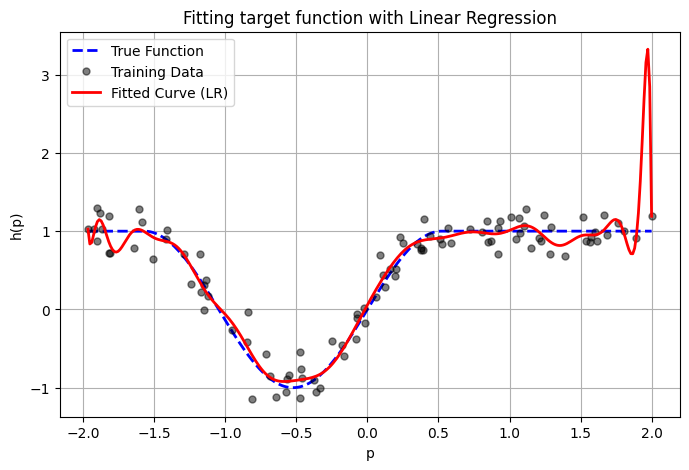

In [18]:
# Generate the training data
data_gen = GenerateData(num_samples=100, case=4)
np.random.seed(8042) # for reproducibility
data_gen.set_noise(mean=0.0, std=0.2) # (I.I.D.) zero-mean Gaussian noise
p, h = data_gen.generate_data()


# Generate basis functions
basis = generate_basis_functions(include_offset, include_polynomial, include_trigonometric, min_poly_order, max_poly_order)


# Fit the model using linear regression
model_lr = Identifier_LR(basis)
model_lr.fit(p, h)
print(model_lr.get_params())


# Visualize the results
true_func = data_gen.get_symbolic_function()
model_lr.plot(true_func=true_func, title='Fitting target function with Linear Regression')

From the plot, we observe that the fitted curve deviates significantly from the true function, especially near the boundaries. This indicates that the model is overfitting the high-frequency noise present in the data due to the use of overly expressive basis functions.

In contrast, we now attempt to reduce the number of basis functions by omitting the trigonometric series and using the following simplified basis function set:

- Basis functions: 1) constant offset $ \phi(\zeta) = 1 $;   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2) polynomial series $ \phi(\zeta) = \zeta^i $ with $ i \in [1, ..., 10] $;

In [19]:
# Define basis functions
include_offset=True
include_polynomial=True
include_trigonometric=False # turn to False
min_poly_order=1
max_poly_order=10
min_freq=1
max_freq=10

[[ 0.05844052]
 [ 2.71249418]
 [-0.5294578 ]
 [-3.58312943]
 [ 1.66697825]
 [ 1.77822185]
 [-0.97007888]
 [-0.3917443 ]
 [ 0.2240525 ]
 [ 0.03227933]
 [-0.01833304]]


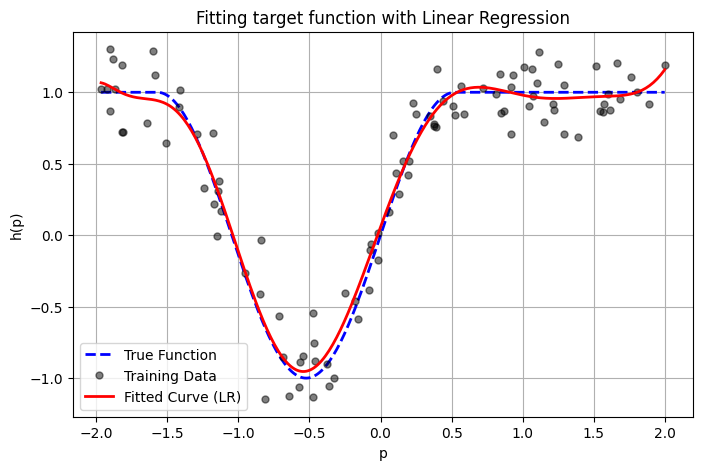

In [20]:
# Generate the training data
data_gen = GenerateData(num_samples=100, case=4)
np.random.seed(8042) # for reproducibility
data_gen.set_noise(mean=0.0, std=0.2) # (I.I.D.) zero-mean Gaussian noise
p, h = data_gen.generate_data()


# Generate basis functions
basis = generate_basis_functions(include_offset, include_polynomial, include_trigonometric, min_poly_order, max_poly_order)


# Fit the model using linear regression
model_lr = Identifier_LR(basis)
model_lr.fit(p, h)
print(model_lr.get_params())


# Visualize the results
true_func = data_gen.get_symbolic_function()
model_lr.plot(true_func=true_func, title='Fitting target function with Linear Regression')

#### **Results Analysis**

From the plot above, we can see that the new model—constructed using fewer and more appropriate basis functions—achieves a much better fit to the noisy data. The fitted curve captures the overall trend of the target function while avoiding the large oscillations and boundary artifacts seen previously.

This leads to an important lesson: **when dealing with real-world data, we should aim to use more appropriate basis functions rather than simply more of them.** Achieving this often requires some prior knowledge of the target function's characteristics (e.g., smoothness, periodicity, flat regions). Leveraging such insights can significantly improve fitting quality and reduce the risk of overfitting noisy samples.


<br>

----

### **Part 2: Bayesian Linear Regression**


#### **Example 2.1: Implementation of Bayesian Linear Regression**

In this example, we start with introducing the formulation of Bayesian Linear Regression (BLR). Based on this foundation, we present a corresponding implementation and apply it to a concrete identification task to demonstrate the effectiveness of the BLR approach.

<br>

##### **Theory of Bayesian Linear Regression**

To address the limitations of maximum likelihood estimation, especially in low-data or noisy regimes, Bayesian linear regression (BLR) introduces a probabilistic view over the model parameters. We assume the same linear model structure as in standard regression:

$$
f(x, u) \approx f_{\text{BLR}}(\zeta) = \theta^\top \phi(\zeta),
$$

but instead of estimating a single point $\theta$, we place a **Gaussian prior** over the parameters:

$$
\theta_{\text{prior}} \sim \mathcal{N}(\mu_0, \Sigma_0).
$$

Given a dataset $\{ \zeta^{(d)}, \gamma^{(d)} \}_{d=1}^D$, the posterior distribution of $\theta$ is also Gaussian:

$$
\theta_{\text{posterior}} \sim \mathcal{N}(\hat{\mu}_\theta, \hat{\Sigma}_\theta),
$$

with

$$
\begin{aligned}
\hat{\mu}_\theta &= \hat{\Sigma}_\theta \left( \Sigma_0^{-1} \mu_0 + \sigma^{-2} \Phi^\top \Gamma \right), \\
\hat{\Sigma}_\theta^{-1} &= \Sigma_0^{-1} + \sigma^{-2} \Phi^\top \Phi.
\end{aligned}
$$

This leads to a predictive distribution over outputs at any test input $\zeta^*$:

$$
\begin{aligned}
\hat{\mu}_{\text{BLR}}(\zeta^*) &= \hat{\mu}_\theta^\top \phi(\zeta^*), \\
\hat{\sigma}^2_{\text{BLR}}(\zeta^*) &= \sigma^2 + \phi(\zeta^*)^\top \hat{\Sigma}_\theta \phi(\zeta^*),
\end{aligned}
$$

capturing both the **data noise** and the **model uncertainty** induced by parameter uncertainty.

This formulation lays the foundation for our Bayesian regression implementation:



In [21]:
def fit(self, p, h):
    p = p.reshape(-1, 1)
    h = h.reshape(-1, 1)
    Phi = np.hstack([f(p) for f in self.basis_functions])  # N x B
    B = Phi.shape[1]

    # Set prior mean and covariance
    mu0 = self.mu0_user if self.mu0_user is not None else np.zeros((B, 1))
    Sigma0 = self.Sigma0_user if self.Sigma0_user is not None else np.eye(B)

    # Compute posterior
    Sigma0_inv = np.linalg.inv(Sigma0)
    self.Sigma_theta = np.linalg.inv(Sigma0_inv + (1 / self.sigma2) * Phi.T @ Phi)
    self.mu_theta = self.Sigma_theta @ (Sigma0_inv @ mu0 + (1 / self.sigma2) * Phi.T @ h)

    self.theta = self.mu_theta  # for consistency with LR interface
    self.p_train = p
    self.h_train = h

Just like the previous `Identifier_LR` class, we have integrated this implementation into the `Identifier_BLR` class. You can directly instantiate it with a set of basis functions and call the `fit()` method to train the Bayesian model. The interface functions are largely consistent with those in the LR class.

The main differences are as follows:

- The model requires prior hyperparameters $ \mu_0 $ and $ \Sigma_0 $ to be specified at initialization, representing the prior mean and prior covariance of the weights.

- The `fit()` method performs **Bayesian linear regression**, computing both the **posterior mean** $\hat{\mu}_\theta$ and **posterior covariance** $ \hat{\Sigma}_\theta $ of the parameters.

- The `predict()` method returns not only the **predictive mean**, but also the **predictive uncertainty** (standard deviation) at each test input.

- The `plot()` method visualizes the predictive mean along with **±3σ confidence intervals**, providing a visual sense of uncertainty in the model's predictions.


<br>

##### **Demonstration: Parameter Identification with Bayesian Linear Regression**

To demonstrate the effectiveness of the above `Identifier_BLR` implementation, we apply it to the following parameter identification task:  

- Target function: **Profile 4**

- Size of dataset: **1000 input-output pairs** 

- Sampling noise: I.I.D. Zero-Mean Gaussian Noise $w_k \sim \mathcal{N}(0, \sigma^2 I)$ with $\sigma = 0.1$

- Basis functions: 1) constant offset $ \phi(\zeta) = 1 $; 2) polynomial series $ \phi(\zeta) = \zeta^i $ with $ i \in [1, ..., 10] $


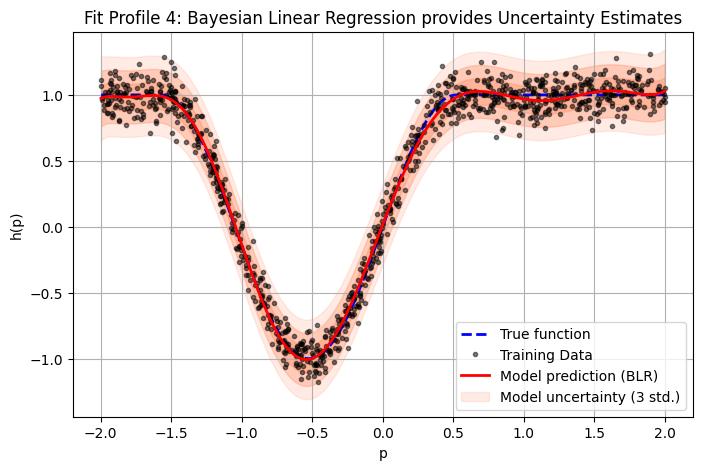

In [22]:
# Generate the training data
data_gen = GenerateData(num_samples=1000, case=4)
np.random.seed(8042) # for reproducibility
data_gen.set_noise(mean=0.0, std=0.1) # (I.I.D.) zero-mean Gaussian noise
p, h = data_gen.generate_data()


# Define basis functions
include_offset=True
include_polynomial=True
include_trigonometric=False
min_poly_order=1
max_poly_order=10


# Generate basis functions
basis = generate_basis_functions(include_offset, include_polynomial, include_trigonometric, min_poly_order, max_poly_order)


# Fit the model using linear regression
model_blr = Identifier_BLR(basis, sigma2=0.01)
model_blr.fit(p, h)

# Visualize the results
true_func = data_gen.get_symbolic_function()
model_blr.plot(true_func=true_func, title='Fit Profile 4: Bayesian Linear Regression provides Uncertainty Estimates')


The BLR model accurately captures the underlying structure of the target function despite the presence of significant observation noise. **Compared to standard linear regression, BLR not only provides a mean prediction but also estimates the variance, effectively capturing a confidence interval around the prediction.** The predictive uncertainty bands (±3σ) adaptively widen in regions with less data or higher noise, offering valuable insight into the model’s confidence in its fit.

<br>

To further highlight the practical importance of uncertainty quantification, it is worth noting that the confidence interval predicted by the Bayesian model is not merely a statistical artifact. Instead, it plays a crucial role in diagnosing the model’s reliability across the input space. By examining where the uncertainty bands widen, we can identify regions where the model is less confident, often due to sparse training data or higher local noise. An example of this behavior is shown below, where the increased variance clearly marks areas where the model's prediction is less trustworthy.

Consider the following sampling scenario: we only collect data from two disjoint intervals, specifically $[−2.0,−1.3]$ and $[0.5,2.0]$. The generated dataset is then used to perform parameter identification using Bayesian Linear Regression (BLR). We analyze the resulting fit and prediction uncertainty.

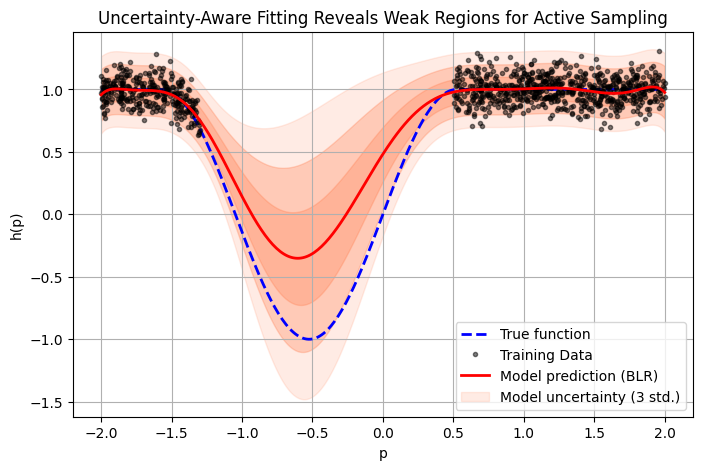

In [23]:
# Generate the training data
data_gen = GenerateData(p_range=[(-2.0, -1.3), (0.5, 2.0)], num_samples=1000, case=4)
np.random.seed(8042) # for reproducibility
data_gen.set_noise(mean=0.0, std=0.1) # (I.I.D.) zero-mean Gaussian noise
p, h = data_gen.generate_data()


# Define basis functions
include_offset=True
include_polynomial=True
include_trigonometric=False
min_poly_order=1
max_poly_order=10


# Generate basis functions
basis = generate_basis_functions(include_offset, include_polynomial, include_trigonometric, min_poly_order, max_poly_order)


# Fit the model using linear regression
num_basis = len(basis)
prior_variance = 10.0
prior_covariance = prior_variance * np.eye(num_basis)
prior_mean = np.zeros((num_basis, 1))
model_blr = Identifier_BLR(basis, sigma2=0.01, mu0=prior_mean, Sigma0=prior_covariance)
# model_blr.fit(np.array([]), np.array([]))
model_blr.fit(p, h)

# Visualize the results
true_func = data_gen.get_symbolic_function()
model_blr.plot(p_test=np.linspace(-2.0, 2.0, 300).reshape(-1, 1), true_func=true_func, title='Uncertainty-Aware Fitting Reveals Weak Regions for Active Sampling')


Compared to the previous scenarios, the BLR model still performs well in the two sampled intervals — the prediction aligns closely with the true function and the uncertainty remains low. However, in the unsampled middle region, the model exhibits a noticeable deviation in the mean prediction, failing to recover the true behavior of the function.

Yet, this degradation is not silent: the widened $\pm 3\sigma$ confidence band clearly indicates the model's low confidence in this region. This suggests a potential strategy for active resampling — by focusing additional data collection in this uncertain region, we can increase confidence and improve prediction accuracy where the current model is weak.

**This example highlights a key advantage of Bayesian Linear Regression: it does not only fit a curve, but also reveals the epistemic uncertainty in the model, offering valuable insight into where the prediction is reliable and where targeted resampling is needed to enhance the model's robustness.**

<br>

#### **Example 2.2: Bayesian Linear Regression vs. Standard Linear Regression**

In this example, we aim to compare the behavior of **Bayesian Linear Regression (BLR)** against standard **Linear Regression (LR)**. We reuse the same identification task introduced in the previous section, and apply both LR and BLR to estimate the model parameters. By varying the dataset size from very small (e.g., $10 \sim 100$ samples) to large (up to $10^3$), we analyze and contrast the performance and characteristics of LR and BLR under different data regimes.


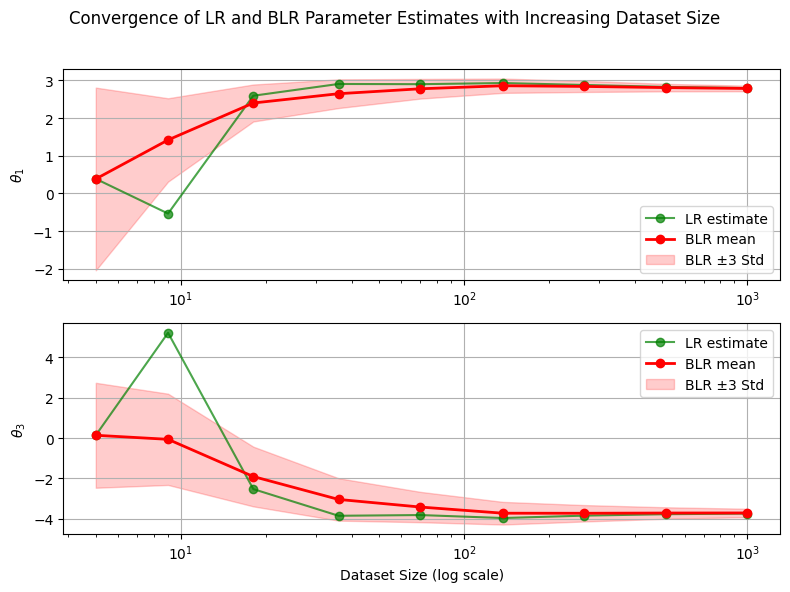

In [24]:
# Generate the training data
data_gen = GenerateData(num_samples=1000, case=4)
np.random.seed(8042) # for reproducibility
data_gen.set_noise(mean=0.0, std=0.1) # (I.I.D.) zero-mean Gaussian noise
p, h = data_gen.generate_data()


# Define basis functions
include_offset=True
include_polynomial=True
include_trigonometric=False
min_poly_order=1
max_poly_order=10


# Generate basis functions
basis = generate_basis_functions(include_offset, include_polynomial, include_trigonometric, min_poly_order, max_poly_order)


# Fit the model using linear regression / bayesian linear regression
model_lr = Identifier_LR(basis)
model_blr = Identifier_BLR(basis, sigma2=0.01)
plot_param_over_sample_size(p, h, model_lr, model_blr, plot_dims=[1, 3], 
                            title='Convergence of LR and BLR Parameter Estimates with Increasing Dataset Size')

#### **Results Analysis**

During the training process, we observe that **Bayesian Linear Regression** and standard **Linear Regression** exhibit noticeably different behaviors, especially in terms of model confidence and robustness to data sparsity.

- BLR provides not only a mean estimate of the model output but also a quantification of prediction uncertainty through a posterior variance. This is visualized in the training plots where LR offers a single estimate line, while BLR displays a shaded region indicating the ±3 standard deviations of model confidence.

- As the dataset size increases, both LR and BLR tend to converge toward similar predictions. However, in the low-data regime, LR estimates can exhibit strong fluctuations and instability across training runs. In contrast, BLR yields a smoother convergence behavior due to the regularizing effect of its prior.



To better understand the latter difference, we extract several representative plots at varying sample sizes (e.g., 8, 10, 100, 1000), where the contrast between LR and BLR becomes particularly instructive.

In [25]:
# Display animation to show the fitting result at given iteration index sequentially
true_func = data_gen.get_symbolic_function()
animate_training_progress(p, h, model_lr, model_blr, sample_indices=[8, 10, 100, 1000], true_func=true_func, title='Impact of Small Dataset on LR vs. BLR: Overfitting vs. Confidence-Aware Fitting')


#### **Results Analysis**

1) Small Sample Regime (e.g., D = 8, 10):

   - LR exhibits clear signs of overfitting, with the fitted curve oscillating wildly to pass through sparse and noisy data points.

   - In contrast, BLR maintains a smooth and relatively conservative prediction, with a large uncertainty region that reflects limited confidence due to insufficient data.

   - This demonstrates that BLR can effectively regularize the solution by incorporating prior beliefs, making it significantly more stable when data is limited.

2) Medium to Large Sample Regime (e.g., D = 100, 1000):

   - Both LR and BLR yield accurate and smooth approximations of the ground truth function.

   - The posterior uncertainty in BLR narrows as data accumulates, and the predictive mean closely aligns with LR’s deterministic estimate.

   - This convergence confirms the asymptotic consistency of BLR.

#### **🧠 Deeper Insight: Why BLR Works Better with Small $D$?**

The superiority of BLR in low-data scenarios stems from its **Bayesian treatment of parameter uncertainty**. In BLR, the model parameter $\theta$ is treated as a random variable with a Gaussian prior:
  
  $$
  \theta \sim \mathcal{N}(\mu_0, \Sigma_0)
  $$

After observing data $\{\zeta^{(d)}, \gamma^{(d)}\}_{d=1}^D$, the posterior distribution of $\theta$ becomes:
  
  $$
  \theta \mid \mathcal{D} \sim \mathcal{N}(\hat{\mu}_\theta, \hat{\Sigma}_\theta)
  $$

where:
  
  $$
  \hat{\Sigma}_\theta^{-1} = \Sigma_0^{-1} + \frac{1}{\sigma^2} \Phi^\top \Phi,
  \quad
  \hat{\mu}_\theta = \hat{\Sigma}_\theta \left( \Sigma_0^{-1} \mu_0 + \frac{1}{\sigma^2} \Phi^\top \Gamma \right)
  $$

The predictive variance is given by:
  
  $$
  \hat{\sigma}^2_{\text{BLR}}(p^*) = \sigma^2 + \phi(p^*)^\top \hat{\Sigma}_\theta \phi(p^*)
  $$

When the dataset size $D$ is small, $\Phi^\top \Phi$ is low-rank and contains limited information about the true function. In such cases:

- The **prior term** $\Sigma_0^{-1}$ dominates in $\hat{\Sigma}_\theta^{-1}$, which helps stabilizing the update and preventing overconfident or extreme parameter estimates.

- The resulting predictive distribution reflects **greater uncertainty** (extraly introduced by $\Sigma_0$), as visualized by the wider confidence intervals in BLR.

- This serves as a **Bayesian regularizer**, enabling the model to generalize better under small-sample conditions.

Hence, BLR not only offers a principled probabilistic measure of **model uncertainty**, guiding more informed decisions, but also produces more stable predictions with limited data.


<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **💡 Take-away 5: Advantages of Bayesian Linear Regression over Standard Linear Regression**

Bayesian Linear Regression (BLR) offers two key advantages over standard Linear Regression:  

1) It provides richer information by modeling the full **distribution** of predictions, including uncertainty bands.  

   - This can be particularly beneficial for **active data collection**, as regions with higher prediction uncertainty can be prioritized for sampling.  
   
   - Furthermore, the estimated uncertainty bounds will become valuable in the **next chapter**, where they can be directly integrated into learning-based control algorithms to ensure safety or robustness.  


2) It demonstrates **more stable training behavior**, with smoother convergence and reduced sensitivity to dataset size—especially in low-data regimes.


</blockquote>